In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO

In [2]:
img_size = 640  # Standard size for YOLO models
# Image paths
image_paths = [
    'Car/data/training_images/vid_4_600.jpg',
    'Car/data/training_images/vid_4_620.jpg',
    'Car/data/training_images/vid_4_940.jpg',
    'Car/data/testing_images/vid_5_400.jpg',
    'Car/data/testing_images/vid_5_420.jpg',
    'Litter/31761220157_02ee12cbaa_z.jpg',
    'Litter/32911398817_4725c65593_z.jpg',
    'Litter/32911402747_4725bfdd20_z.jpg',
    'Litter/32911404057_297c502eef_z.jpg',
    'Litter/32911404467_6bb8e83d98_z.jpg'
]


In [3]:
def preprocess_image(img_path, img_size):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize to model's input size
    img_resized = cv2.resize(img, (img_size, img_size))
    
    return img_resized

def predict_with_yolo(model, img):
    # Convert to torch tensor
    img_tensor = torch.tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    
    # Get predictions
    with torch.no_grad():
        preds = model(img_tensor)
    
    return preds

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


0: 640x640 1 car, 5 traffic lights, 234.3ms
Speed: 0.0ms preprocess, 234.3ms inference, 1095.8ms postprocess per image at shape (1, 3, 640, 640)
Processed Car/data/training_images/vid_4_600.jpg, detections: 6


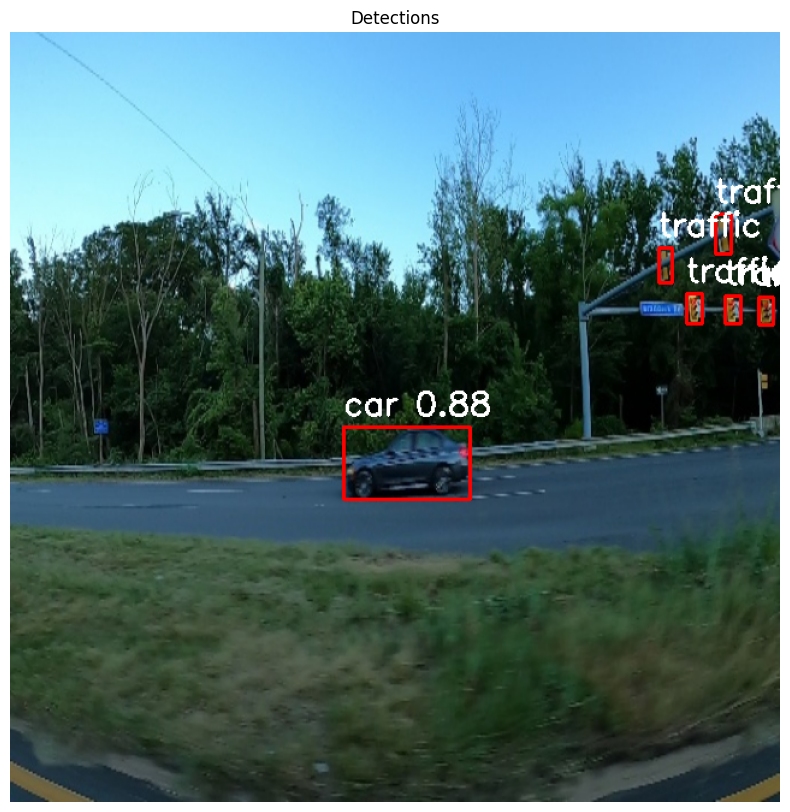


0: 640x640 1 car, 8 traffic lights, 215.5ms
Speed: 0.0ms preprocess, 215.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Processed Car/data/training_images/vid_4_620.jpg, detections: 9

0: 640x640 2 cars, 210.9ms
Speed: 0.0ms preprocess, 210.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Processed Car/data/training_images/vid_4_940.jpg, detections: 2

0: 640x640 1 car, 189.5ms
Speed: 0.0ms preprocess, 189.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Processed Car/data/testing_images/vid_5_400.jpg, detections: 1

0: 640x640 1 car, 1 surfboard, 182.7ms
Speed: 0.0ms preprocess, 182.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Processed Car/data/testing_images/vid_5_420.jpg, detections: 2

0: 640x640 1 bottle, 1 scissors, 186.1ms
Speed: 0.0ms preprocess, 186.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Processed Litter/31761220157_02ee12cbaa_z.jpg, detections: 2

0: 640x640 1

In [4]:
model = YOLO("yolov8m.pt")

for img_path in image_paths:
    img = preprocess_image(img_path, img_size)
    preds = predict_with_yolo(model, img)
    
    # Now, we directly access the detections from the Result object
    detections = preds[0].boxes  # Assuming there's at least one detection and one image processed
    
    # Print the number of detections
    print(f"Processed {img_path}, detections: {len(detections)}")
    
    # Visualization for the first image's detections as an example
    if img_path == image_paths[0]:
        for i, (det,cls_id, conf) in enumerate(zip(detections.xyxy, detections.cls, detections.conf)):
            # Extract coordinates and confidence
            x1, y1, x2, y2 = det[:4]
            label = model.names[int(cls_id)]
            img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            cv2.putText(img, f'{label} {conf:.2f}', (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title("Detections")
        plt.axis("off")
        plt.show()

In [5]:
class OD2Score(torch.nn.Module):
    def __init__(self, target_cls_id):
        super(OD2Score, self).__init__()
        self.target_cls_id = target_cls_id

    def forward(self, preds):
        # Filter detections by target class ID and return their confidence scores
        scores = []
        for pred in preds:
            for cls_id, conf in zip(pred.boxes.cls, pred.boxes.conf):
                if cls_id == self.target_cls_id:
                    scores.append(conf.item())
        # Aggregate scores (e.g., by taking max or average)
        return np.array(scores).max() if scores else 0


In [6]:
class SuperPixler(torch.nn.Module):
    def __init__(self, superpixel_size, img_size):
        super(SuperPixler, self).__init__()
        self.superpixel_size = superpixel_size
        self.img_size = img_size

    def forward(self, img, mask):
        # Assume mask is a binary vector where 1 indicates the presence of a superpixel
        # Split image into superpixels
        # For simplicity, assume square image and superpixels
        num_superpixels = self.img_size // self.superpixel_size
        masked_img = img.clone()
        for i in range(num_superpixels):
            for j in range(num_superpixels):
                if mask[i*num_superpixels + j] == 0:
                    x, y = i*self.superpixel_size, j*self.superpixel_size
                    masked_img[:, x:x+self.superpixel_size, y:y+self.superpixel_size] = 0
        return masked_img


In [7]:
from keras.layers import Input, Dense
from keras.models import Model

# Assuming fixed-size feature vector for each image
input_dim = 100  # Example dimension
input_img = Input(shape=(input_dim,))

# Simple autoencoder architecture
encoded = Dense(64, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Example training call
# autoencoder.fit(features, features, ...)


In [8]:
import numpy as np
import cv2
from skimage.segmentation import slic
from skimage.color import label2rgb

def segment_image_into_superpixels(image, n_segments=100):
    # Convert image to the format expected by skimage (convert from RGB to BGR)
    image_sk = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Apply SLIC segmentation
    segments = slic(image_sk, n_segments=n_segments, compactness=10, sigma=1)
    # Convert segmentation back to original color space
    segmented_image = label2rgb(segments, image_sk, kind='avg')
    segmented_image = cv2.cvtColor(segmented_image.astype('float32'), cv2.COLOR_BGR2RGB)
    return segments, segmented_image

def create_mask_for_superpixel(segmentation, segment_index):
    mask = np.zeros(segmentation.shape, dtype=bool)
    mask[segmentation == segment_index] = True
    return mask

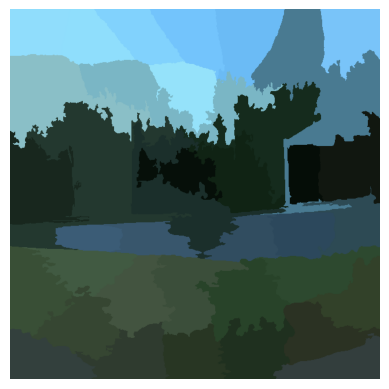

In [15]:
import shap
from PIL import Image

# Prepare a batch of perturbed images
def prepare_perturbed_images(original_image, segmentation):
    masks = []
    perturbed_images = []
    for segment_index in np.unique(segmentation):
        mask = create_mask_for_superpixel(segmentation, segment_index)
        perturbed_image = original_image.copy()
        perturbed_image[mask] = 0  # Masking out the superpixel
        perturbed_images.append(perturbed_image)
        masks.append(mask)
    return np.array(perturbed_images), masks

# Example picture
img_path = 'Car/data/training_images/vid_4_600.jpg'
original_img = preprocess_image(img_path, img_size)
segments, segmented_img = segment_image_into_superpixels(original_img, n_segments=50)


# Display the segmented image
segmented_img_uint8 = segmented_img.astype('uint8')
plt.imshow(segmented_img_uint8)
plt.axis('off') 
plt.show()

perturbed_images, masks = prepare_perturbed_images(original_img, segments)

In [17]:
perturbed_images, masks = prepare_perturbed_images(original_img, segments)


In [19]:
# Loop over perturbed images to predict
for i, perturbed_img in enumerate(perturbed_images):
    preds = predict_with_yolo(model, perturbed_img)


0: 640x640 1 person, 1 car, 5 traffic lights, 240.9ms
Speed: 0.0ms preprocess, 240.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 car, 5 traffic lights, 176.4ms
Speed: 0.0ms preprocess, 176.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 car, 5 traffic lights, 177.1ms
Speed: 0.0ms preprocess, 177.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 car, 5 traffic lights, 176.3ms
Speed: 0.0ms preprocess, 176.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 car, 5 traffic lights, 265.9ms
Speed: 0.0ms preprocess, 265.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 187.1ms
Speed: 0.0ms preprocess, 187.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 car, 5 traffic lights, 177.3ms
Speed: 0.0ms preprocess, 177.3ms inference, 1.6ms postp

In [69]:
def predict_with_yolo_batch(model, imgs):
    # Convert batch of images to torch tensor
    imgs_tensor = torch.tensor(imgs / 255.0, dtype=torch.float32).permute(0, 3, 1, 2)
    
    # Get predictions for the batch
    with torch.no_grad():
        preds = model(imgs_tensor)
    
    # Simplify the output for SHAP analysis; here we use the maximum confidence as an example
    max_confidences = [pred.xyxy[0][:, 4].max().item() if pred.xyxy[0].shape[0] > 0 else 0 for pred in preds]
    return np.array(max_confidences)

def shap_model_function(masks):
    # Apply masks to the original image to create a batch of perturbed images
    perturbed_images = np.array([original_img * mask for mask in masks])
    # Predict with the YOLO model for the batch of perturbed images
    predictions = predict_with_yolo_batch(model, perturbed_images)
    return predictions



In [72]:
# Generate binary masks for each superpixel
num_superpixels = np.unique(segments).size
masks = np.zeros((num_superpixels, *original_img.shape))
for i, seg_val in enumerate(np.unique(segments)):
    mask_2d = create_mask_for_superpixel(segments, seg_val)
    # Replicate the 2D mask across the 3 color channels to create a 3D mask
    mask_3d = np.repeat(mask_2d[:, :, np.newaxis], 3, axis=2)
    masks[i] = mask_3d